<a href="https://colab.research.google.com/github/ryan13/AbnomalyDetection/blob/master/_Demand_forecast_timesharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work is to exple use of DeepLearning (LSTM) to forecast demand at the alternative method of SARIMAX for time series. Data used is [London bike sharing](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset) in Kaggle. Model uses Keras 2.0 and experience with google colab.
Let’s download the data:

In [3]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 33.3MB/s]


In [2]:
pip install tensorflow-gpu

Load libraries

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 18, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


Load data

In [5]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

df.head()


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Let look these features:   
timestamp - timestamp field for grouping the data.  
cnt - the count of a new bike shares.  
t1 - real temperature in C.  
t2 - temperature in C “feels like”.  
hum - humidity in percentage.  
wind_speed - wind speed in km/h.  
weather_code - category of the weather.  
is_holiday - boolean - 1 holiday / 0 non holiday.     
is_weekend - boolean field - 1 if the day is weekend
season - category field seasons:    0-spring ; 1-summer; 2-fall; 3-winter.   

In [6]:
df.shape

(17414, 9)

Create datetime features

In [0]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

Visualize number of rented bikes by each record.

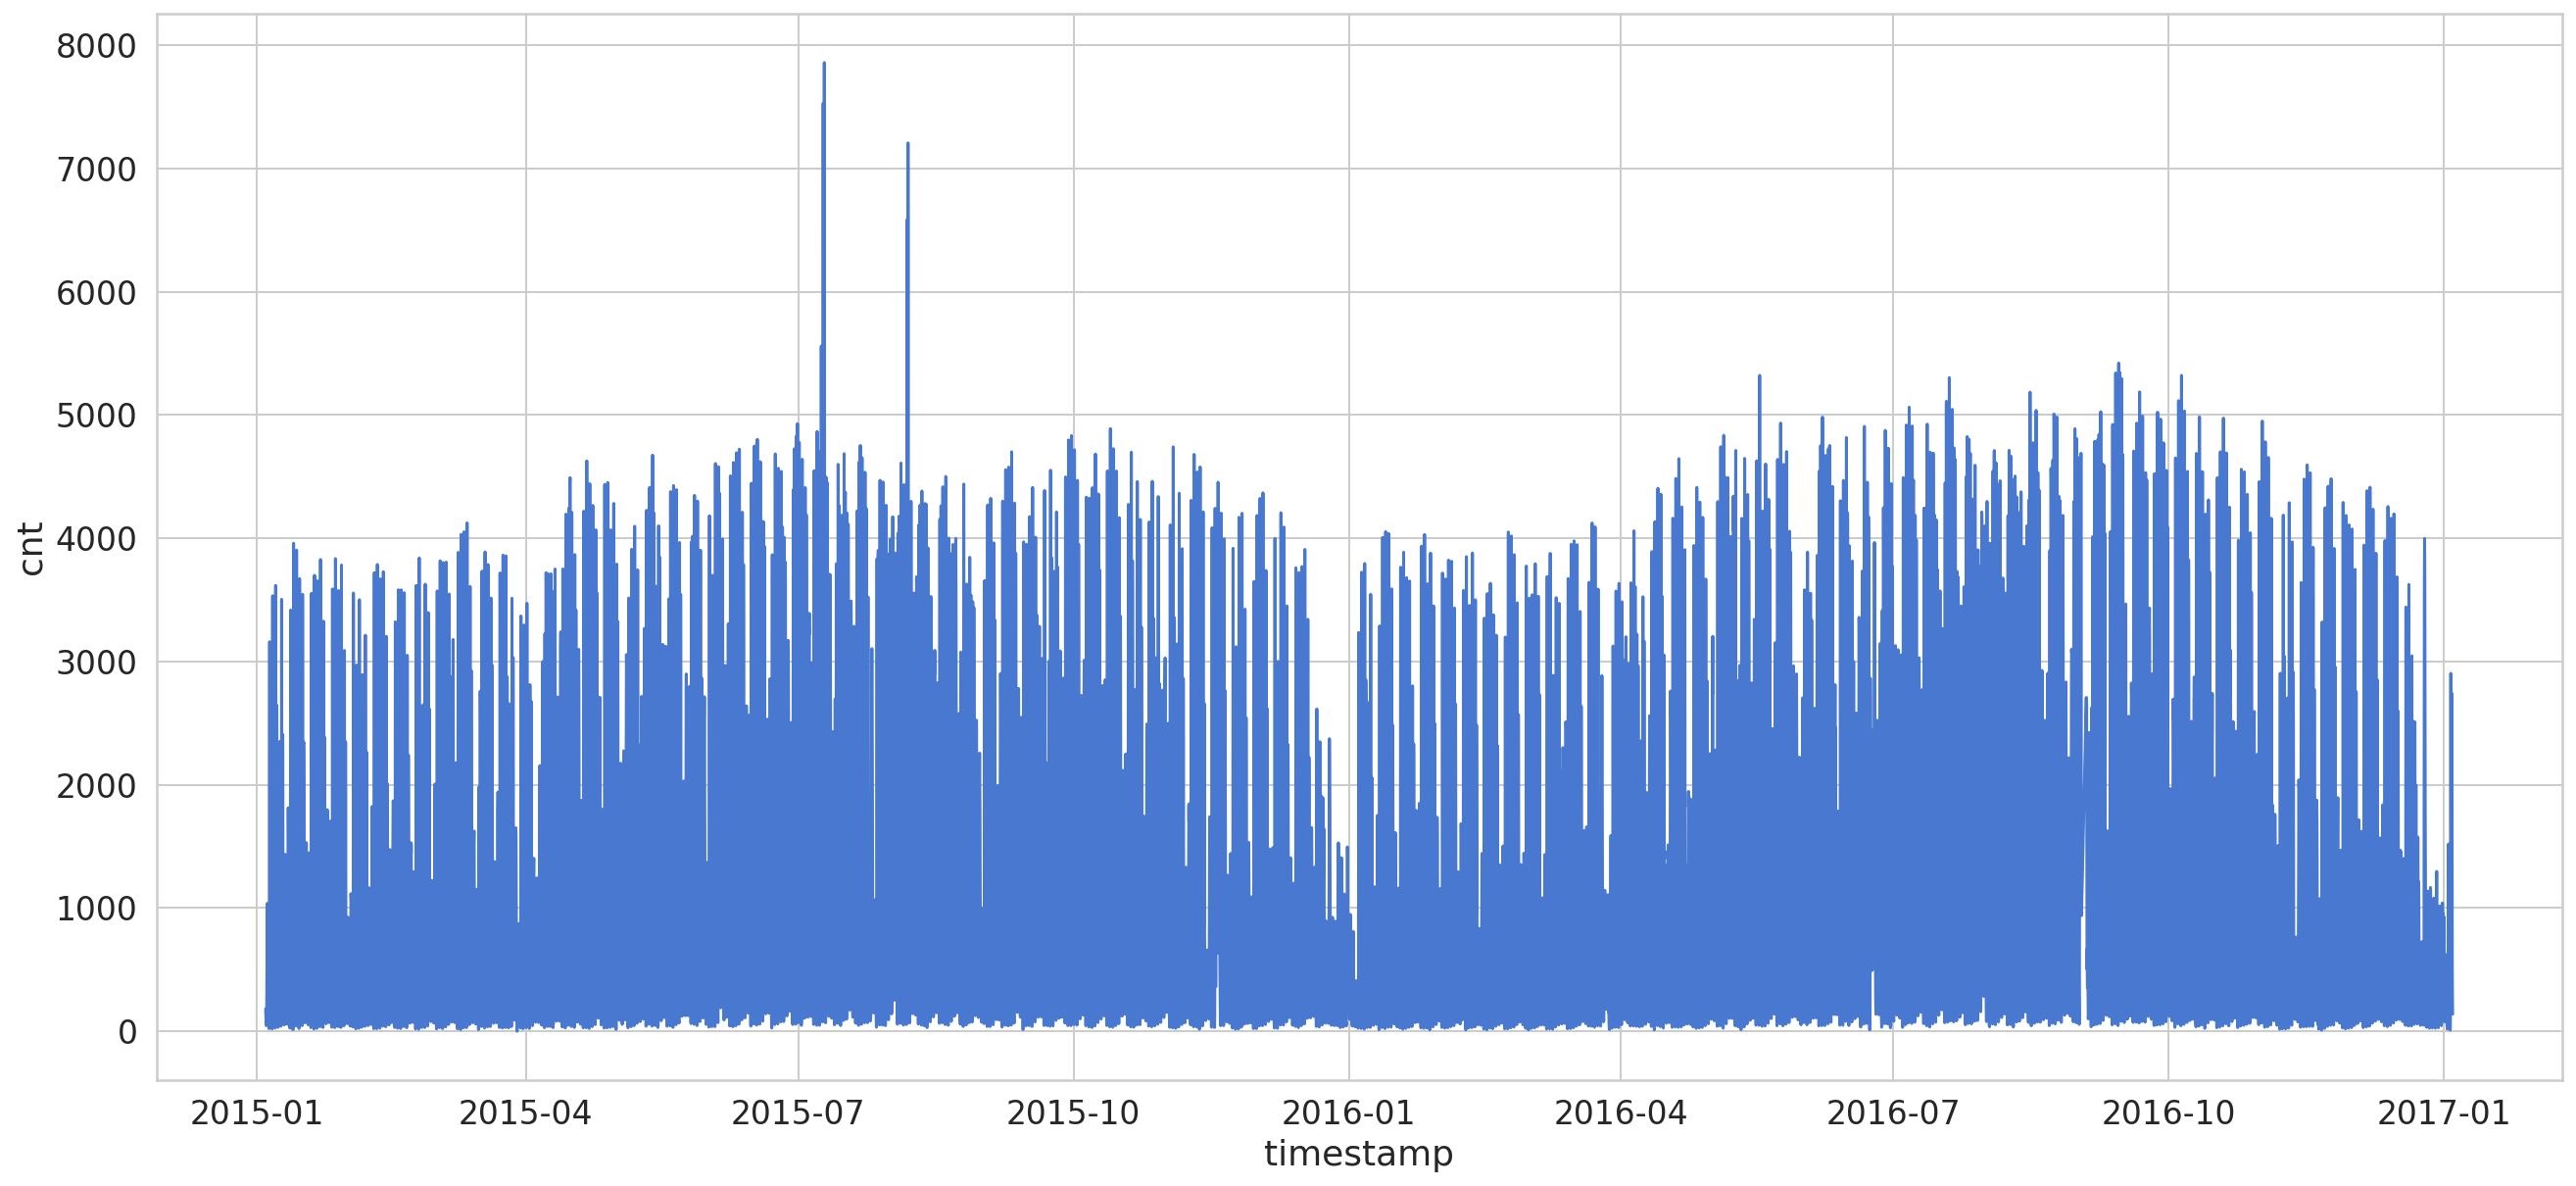

In [8]:
sns.lineplot(x=df.index, y="cnt", data=df);

Visualize rented bike counts by month

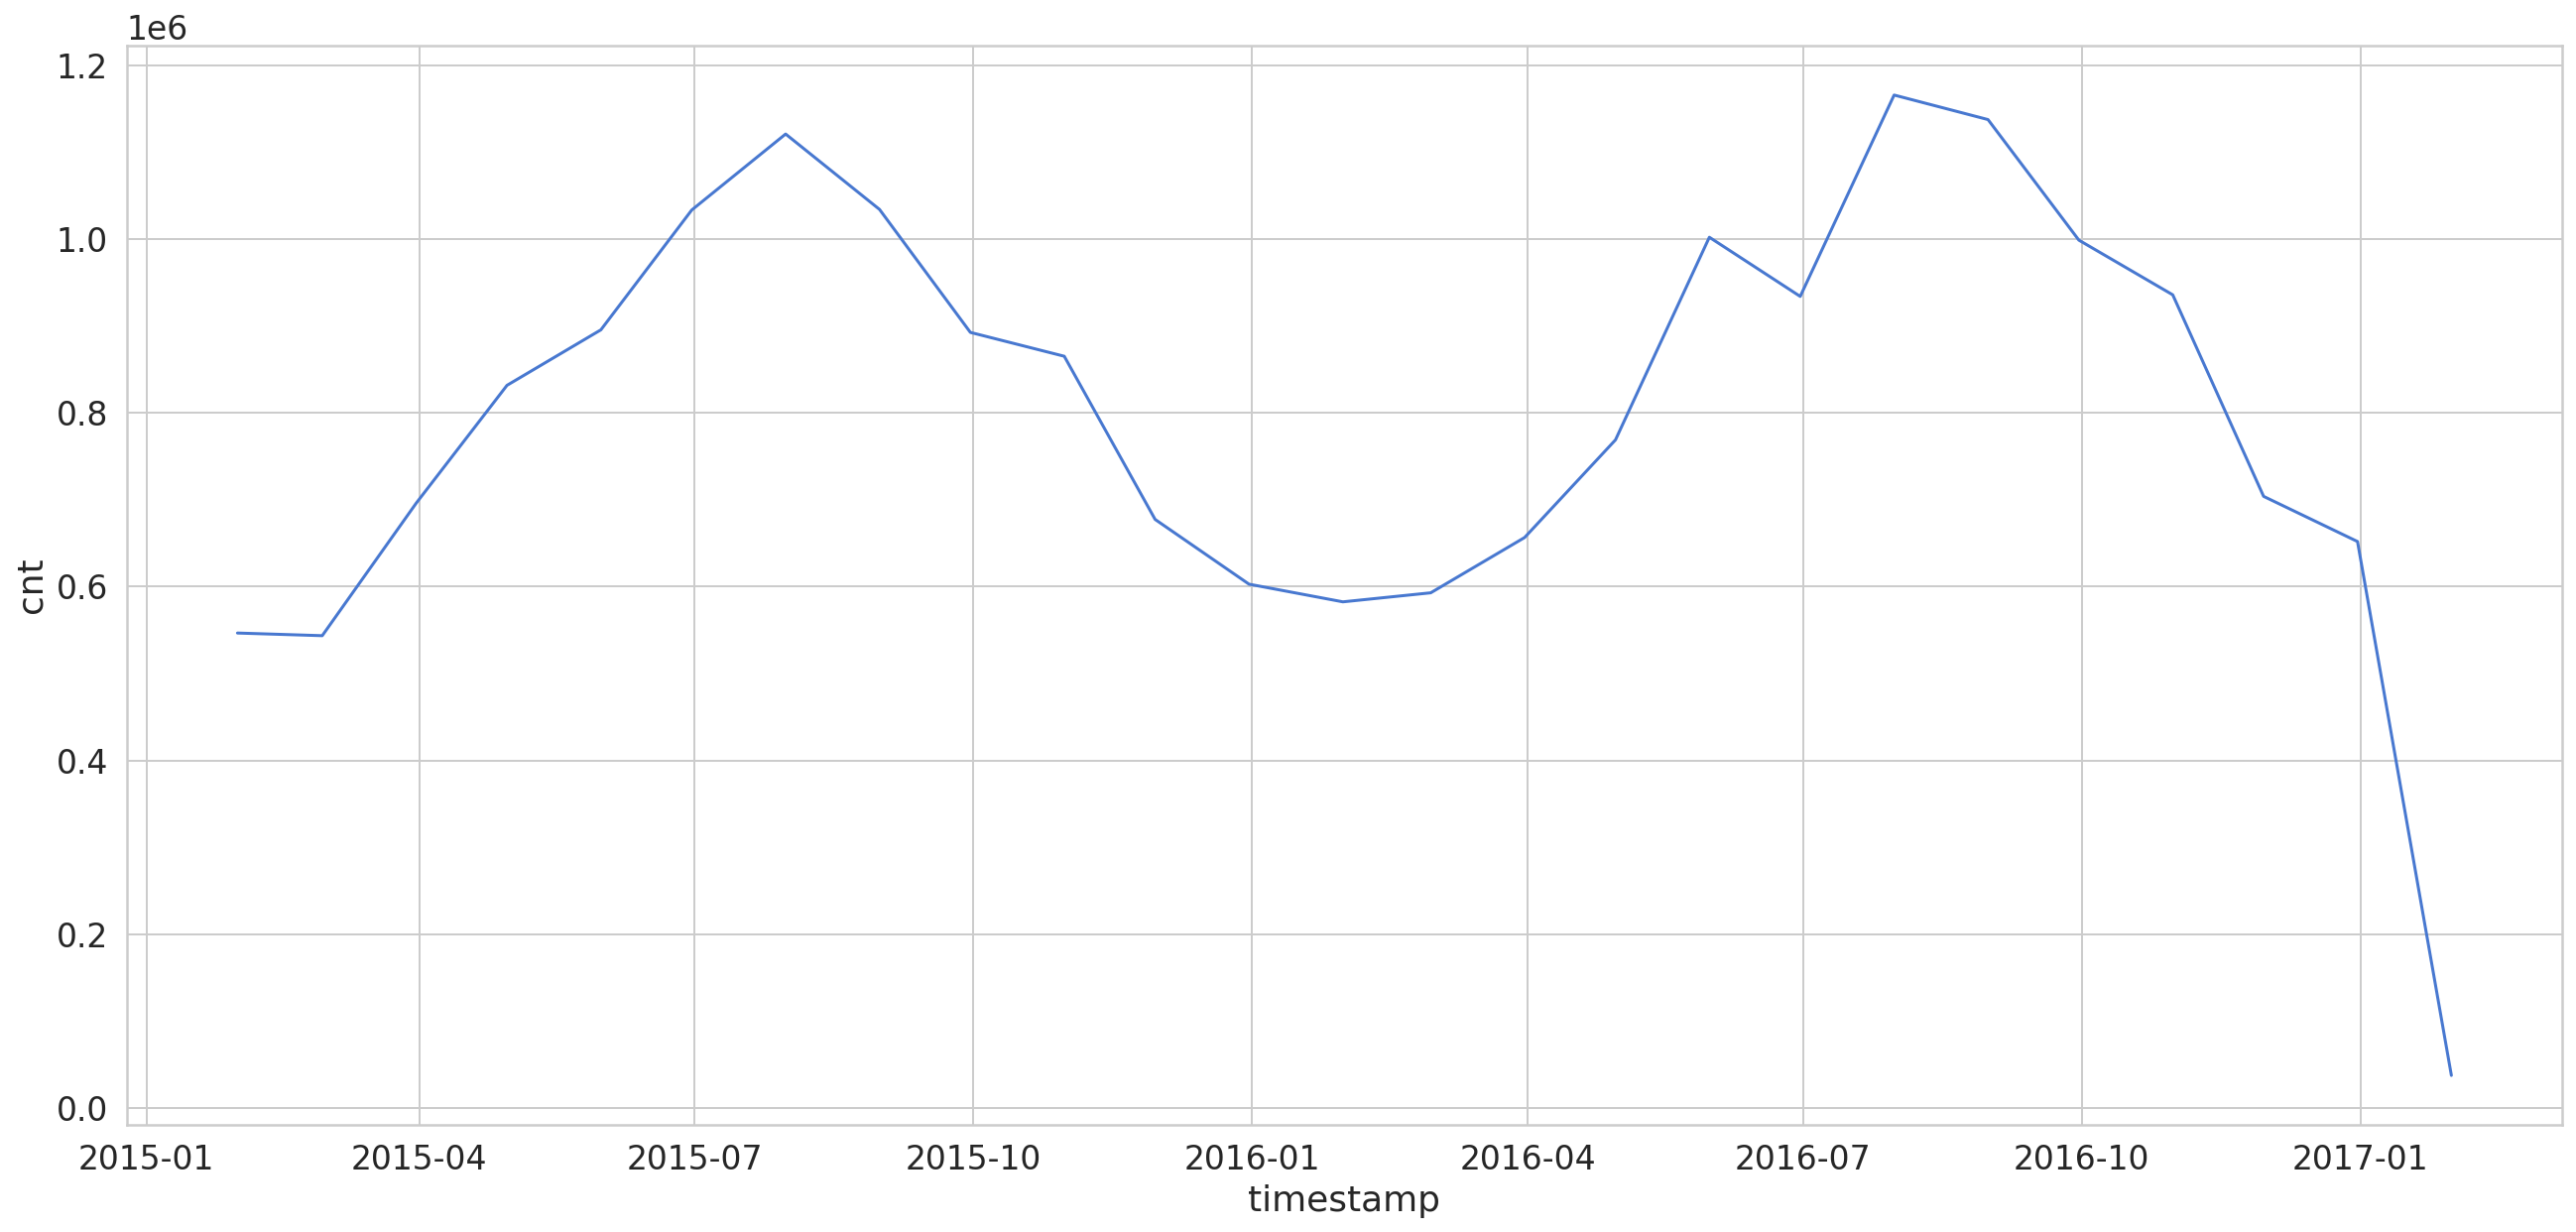

In [11]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

Visualize rented bikes by different time of the day.

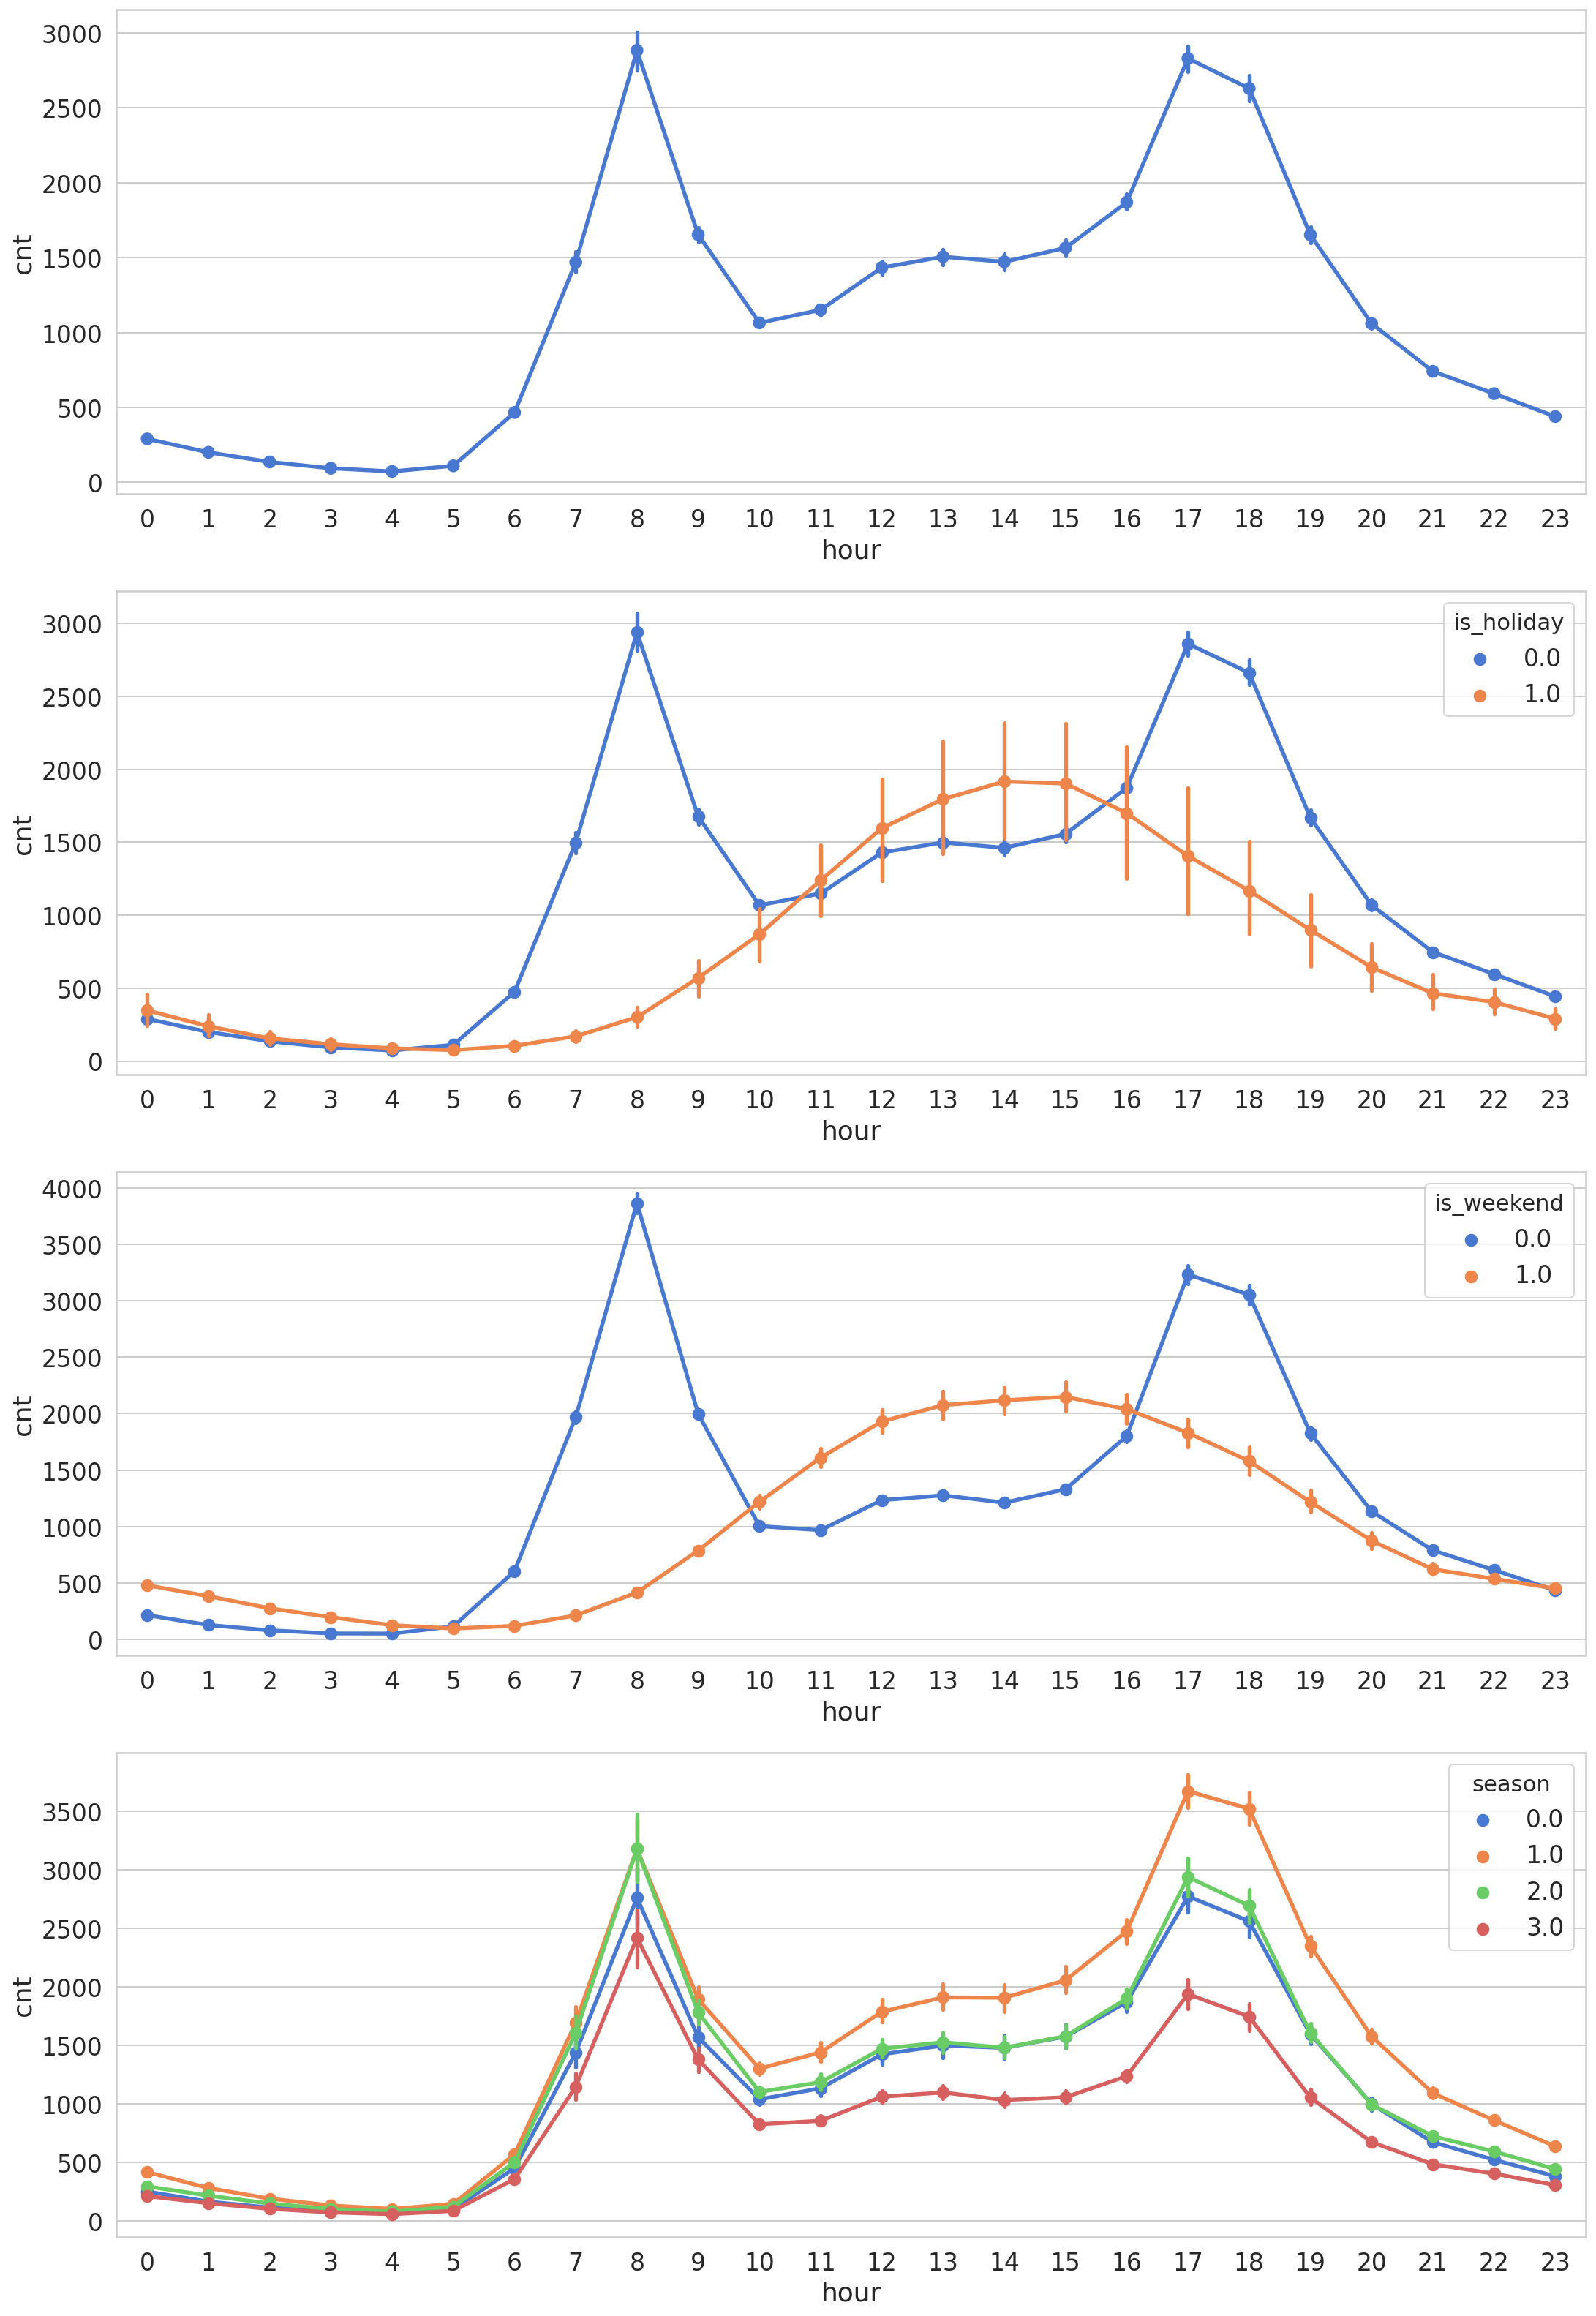

In [10]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

Visualize the number of rented bikes for each day of the week

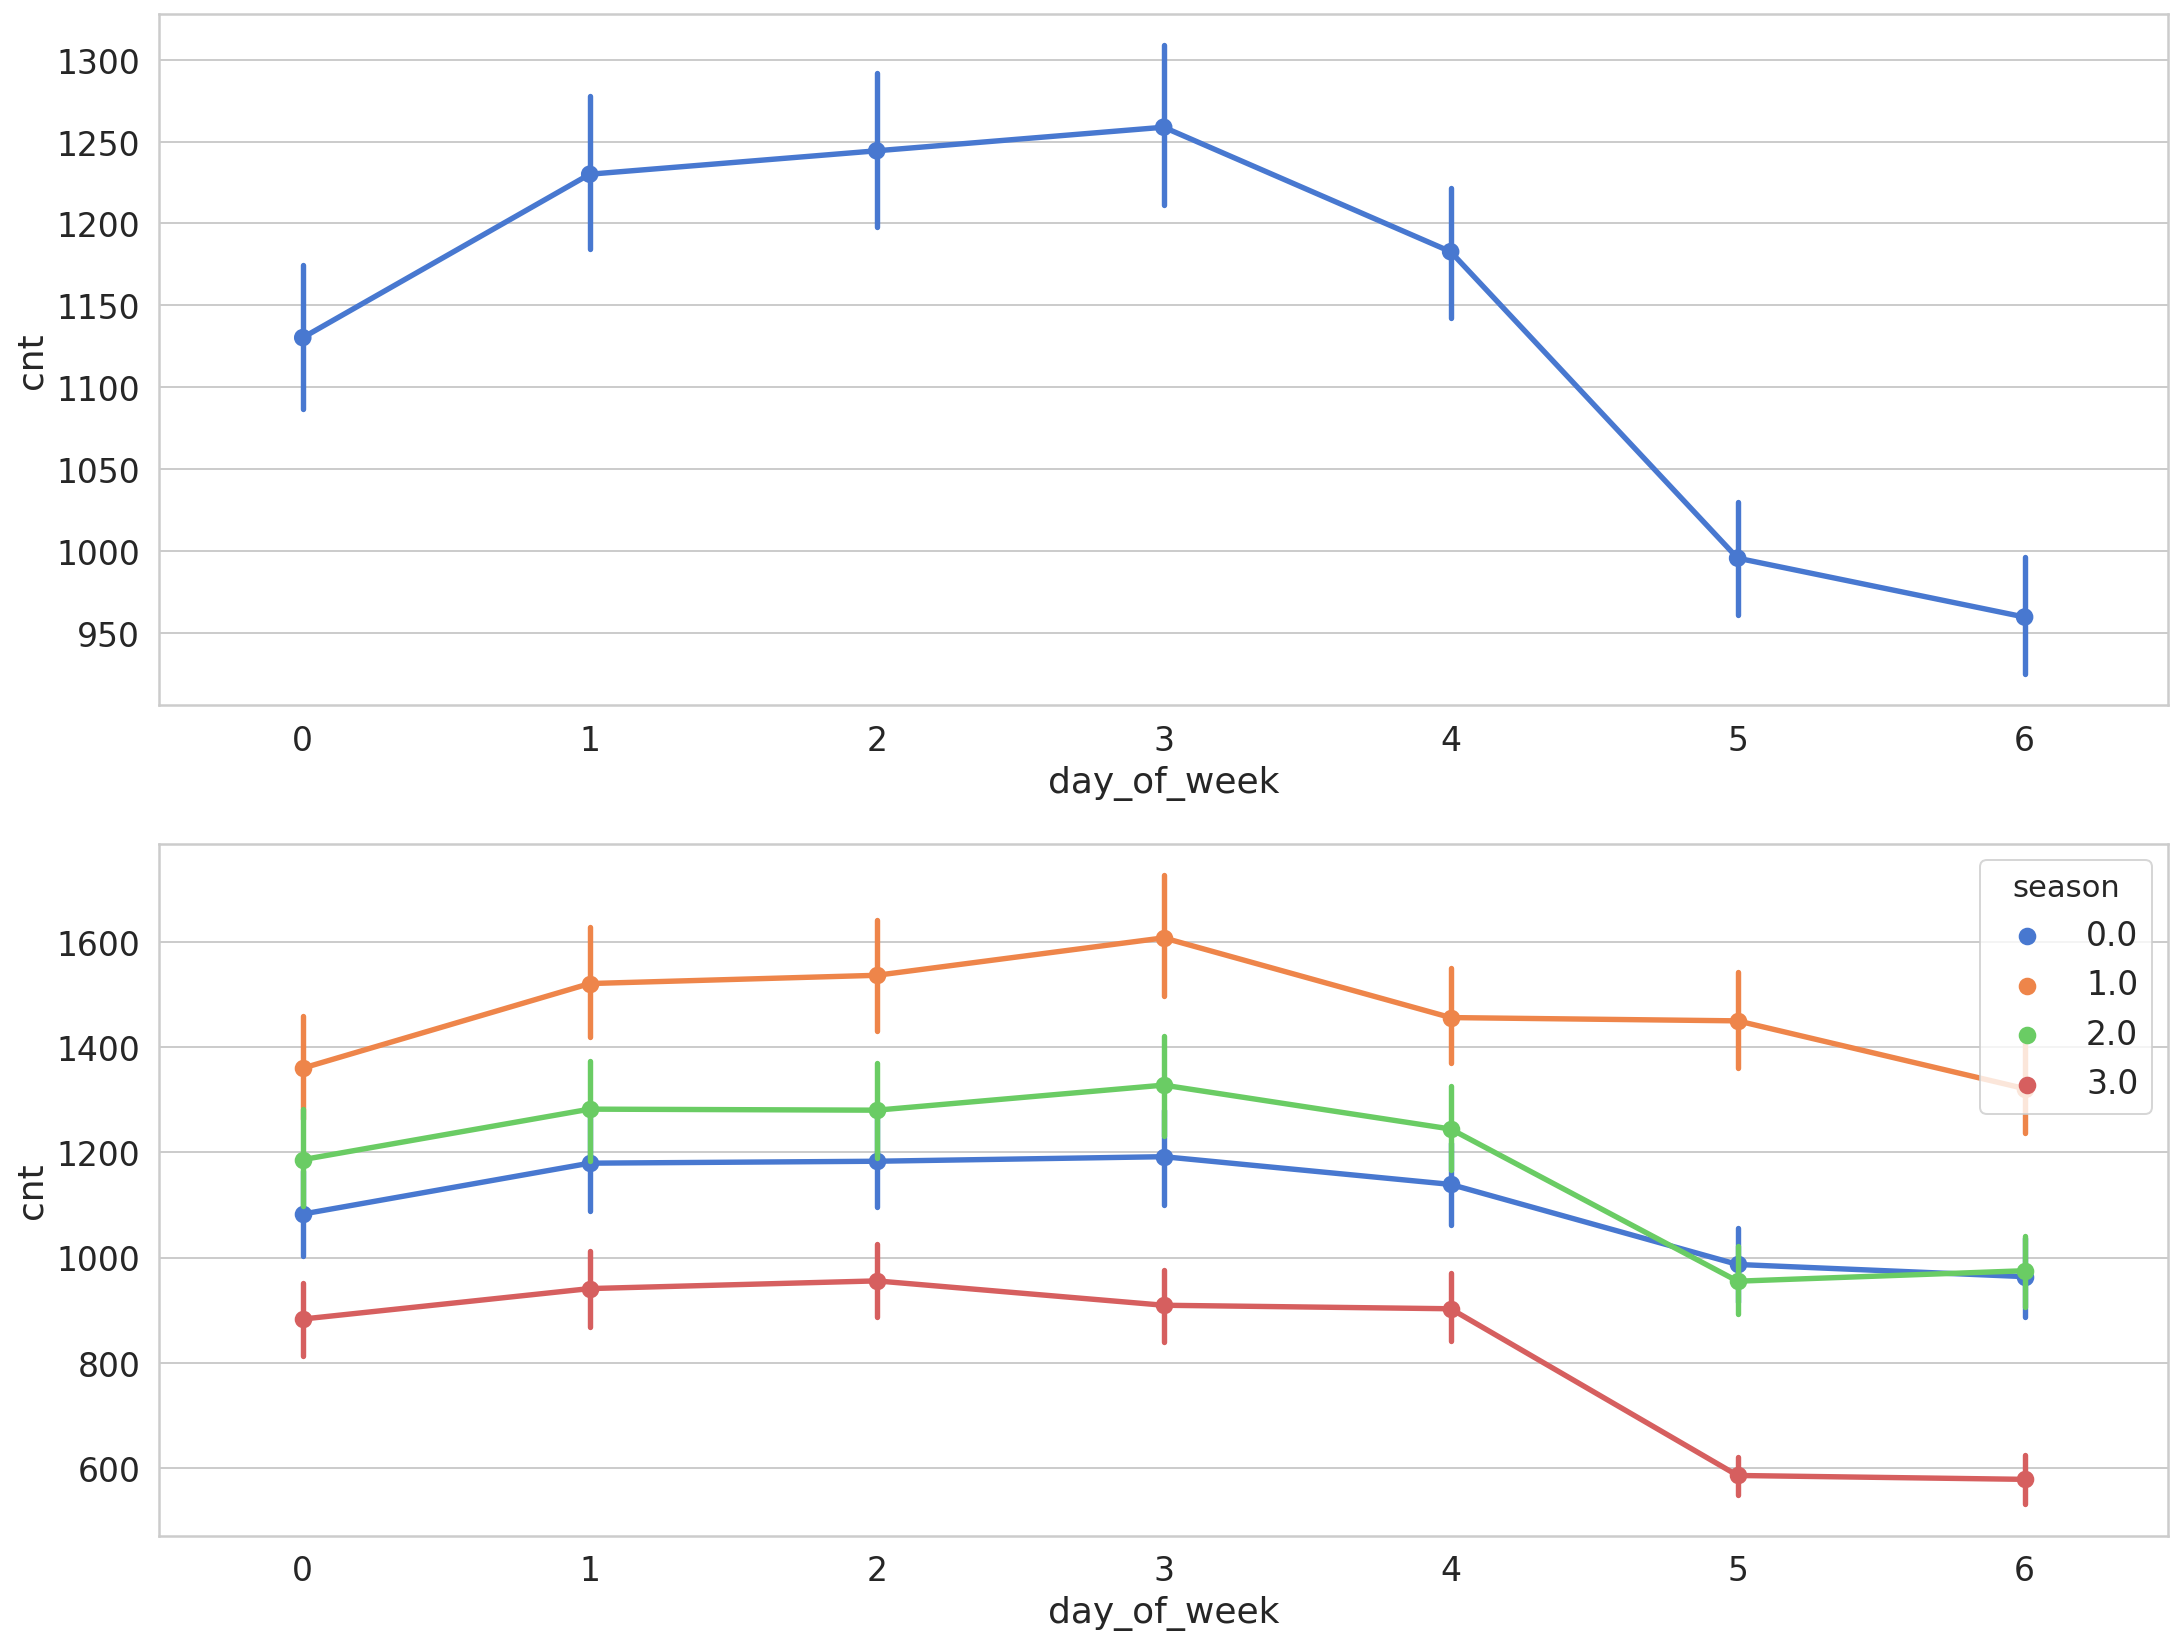

In [11]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

Create train+ test data

In [12]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size].copy(), df.iloc[train_size:len(df)].copy()
print(len(train), len(test))

15672 1742


Scaling data

In [0]:
from sklearn.preprocessing import RobustScaler

cols = ['t1', 't2', 'hum', 'wind_speed']

f_scale = RobustScaler().fit(train[cols].to_numpy())
target_scale = RobustScaler().fit(train[['cnt']])


train.loc[:, cols] = f_scale.transform(train[cols].to_numpy())
train.loc[:,'cnt'] = target_scale.transform(train[['cnt']])

test.loc[:, cols] = f_scale.transform(test[cols].to_numpy())
test.loc[:,'cnt'] = target_scale.transform(test[['cnt']])

Define function to create a new data for LSTM model

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

LSTM input requires a sequence input. Using above function to generate new train, test set

In [19]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


Create Bidirectional LSTM model

In [20]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 14095 samples, validate on 1567 samples
Epoch 1/30
14095/14095 [==============================] - 21s 1ms/sample - loss: 0.2555 - val_loss: 0.1354
Epoch 2/30
14095/14095 [==============================] - 19s 1ms/sample - loss: 0.0797 - val_loss: 0.0514
Epoch 3/30
14095/14095 [==============================] - 19s 1ms/sample - loss: 0.0467 - val_loss: 0.0415
Epoch 4/30
14095/14095 [==============================] - 19s 1ms/sample - loss: 0.0360 - val_loss: 0.0353
Epoch 5/30
14095/14095 [==============================] - 19s 1ms/sample - loss: 0.0330 - val_loss: 0.0448
Epoch 6/30
14095/14095 [==============================] - 19s 1ms/sample - loss: 0.0268 - val_loss: 0.0432
Epoch 7/30
14095/14095 [==============================] - 20s 1ms/sample - loss: 0.0247 - val_loss: 0.0346
Epoch 8/30
14095/14095 [==============================] - 20s 1ms/sample - loss: 0.0248 - val_loss: 0.0323
Epoch 9/30
14095/14095 [==============================] - 19s 1ms/sample - loss: 0.0226 - val_l

Visualize model on train vs test 

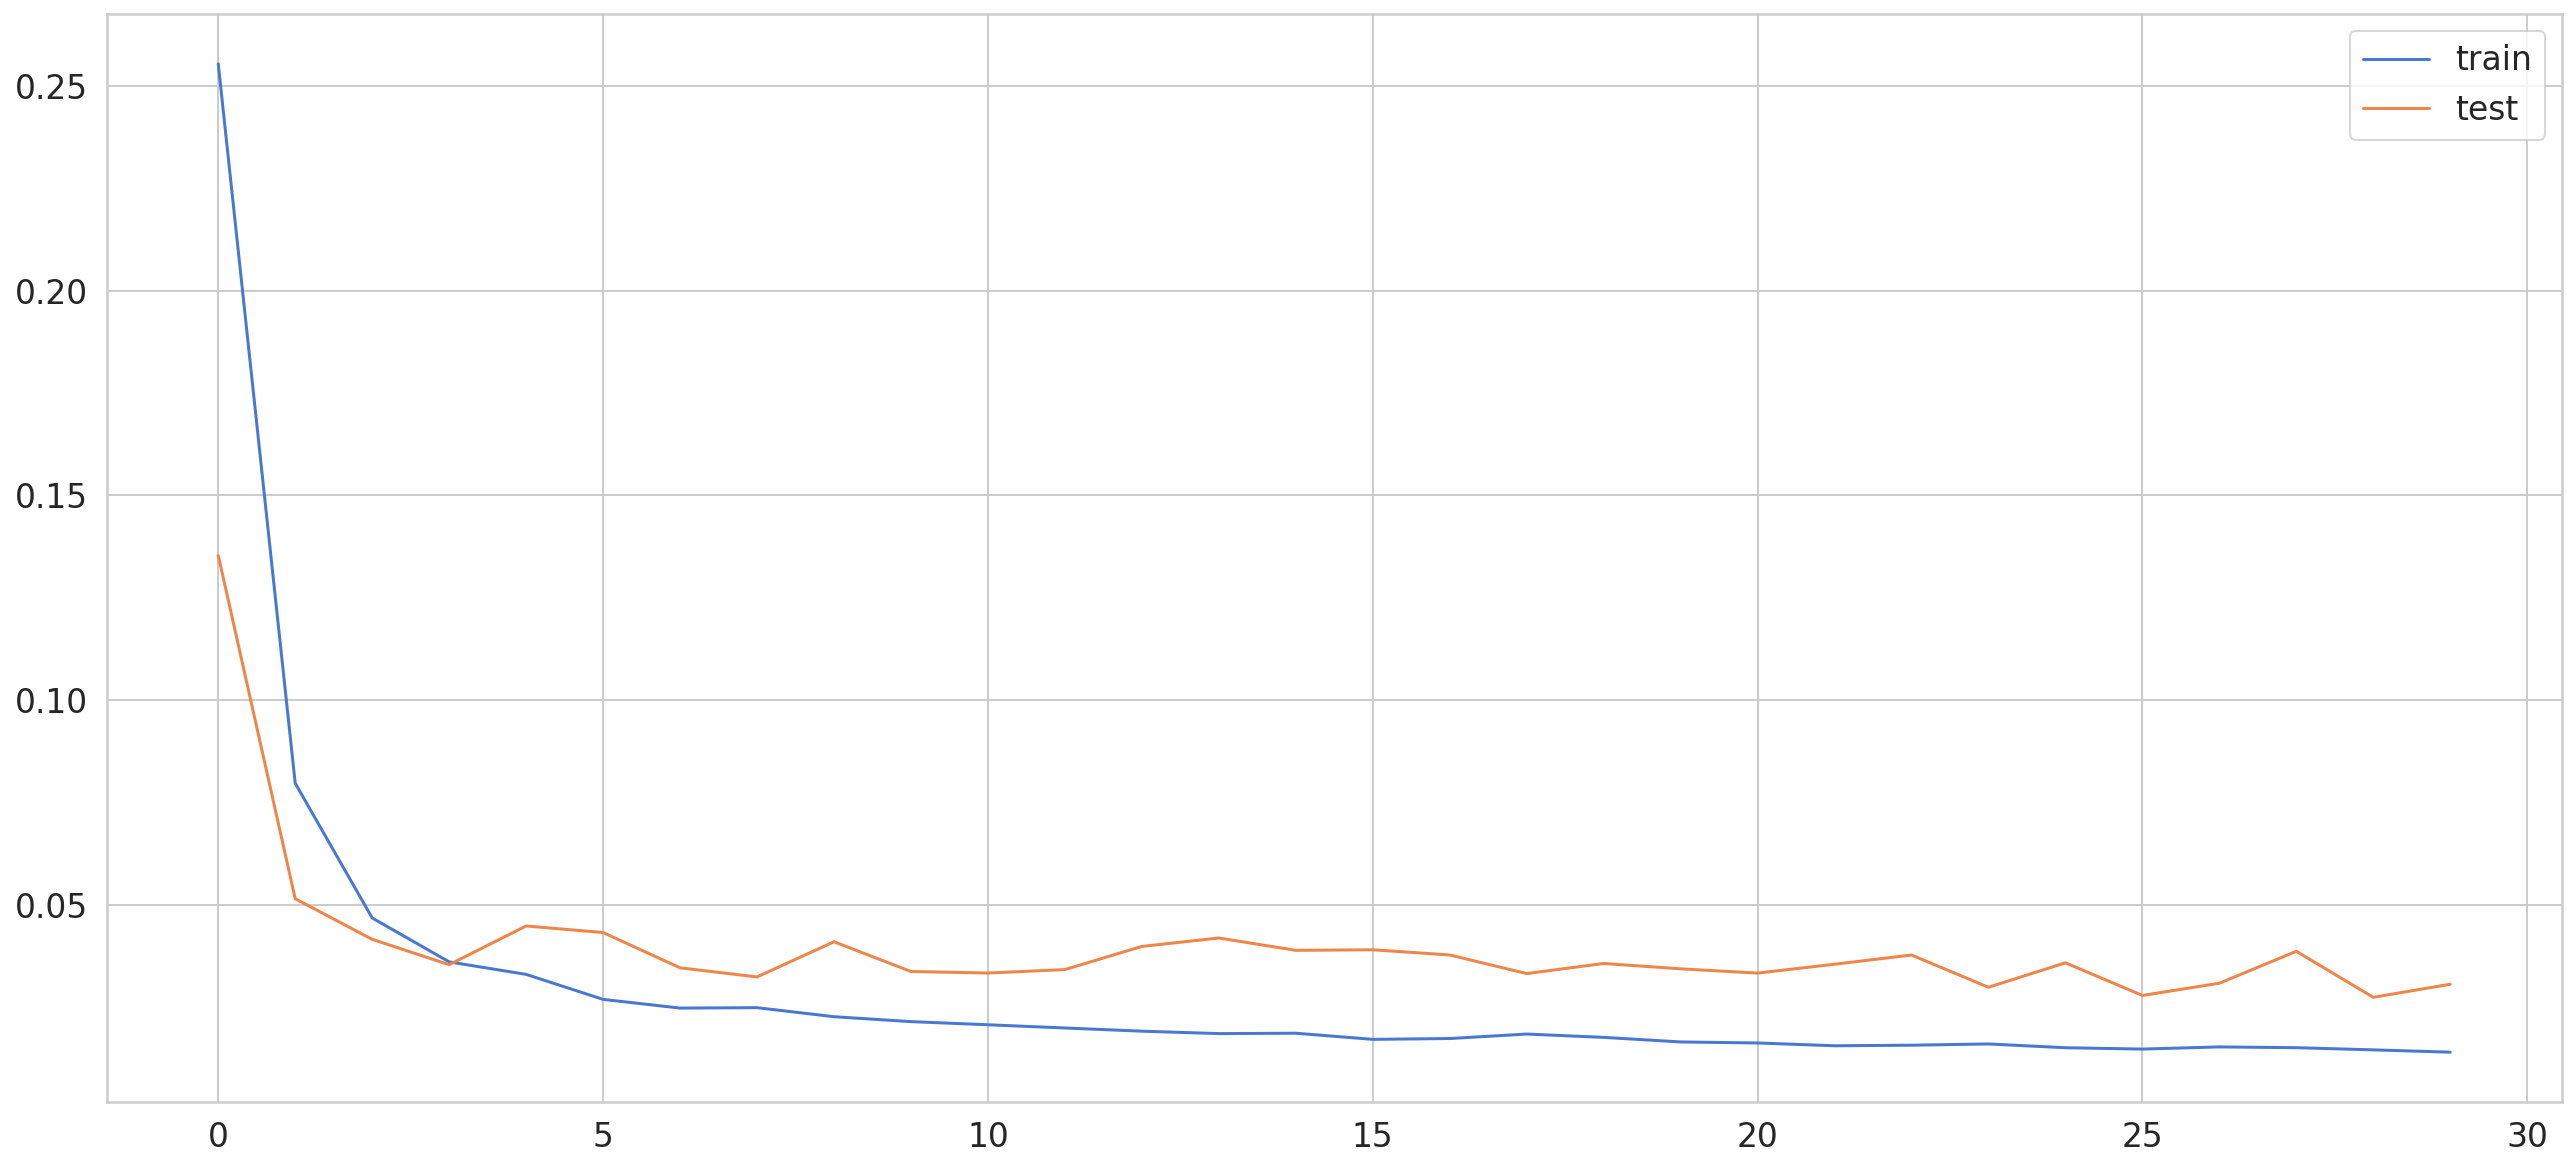

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Predict on test set

In [23]:
y_pred = model.predict(X_test)
y_pred

array([[ 0.44044772],
       [ 0.13184163],
       [-0.11254072],
       ...,
       [-0.28980762],
       [-0.38869047],
       [-0.44774365]], dtype=float32)

Let un_scale back to the original scale

In [0]:
y_train_inv = target_scale.inverse_transform(y_train.reshape(1, -1))
y_test_inv = target_scale.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = target_scale.inverse_transform(y_pred)

Visualize the prediction

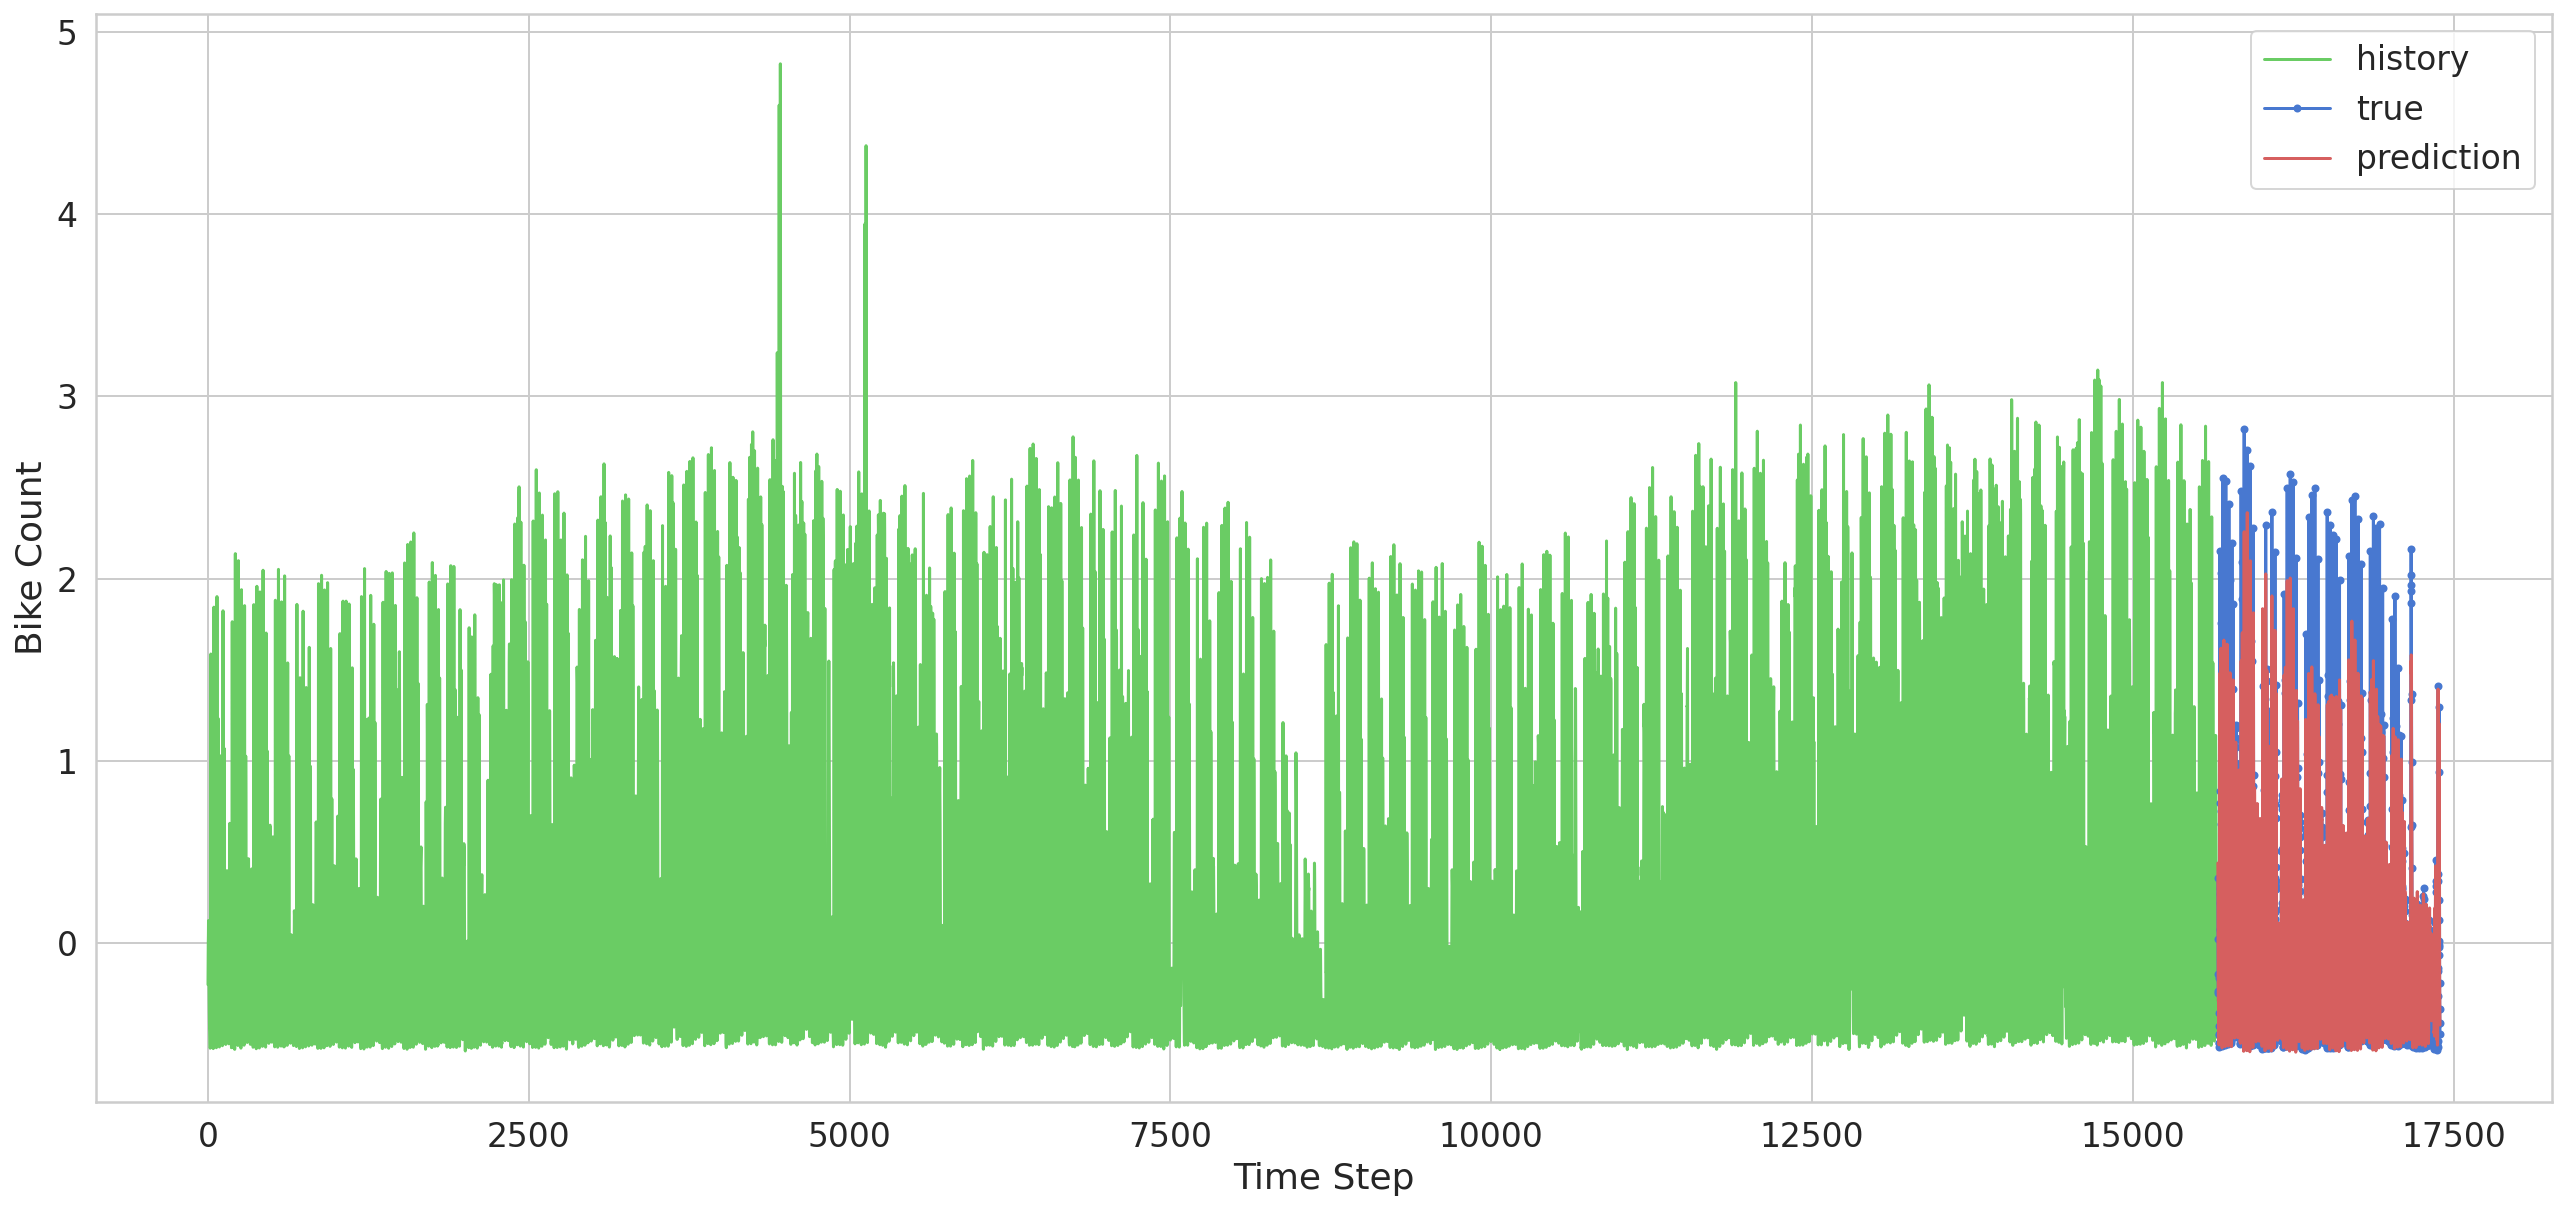

In [26]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Visualize prediction vs true 

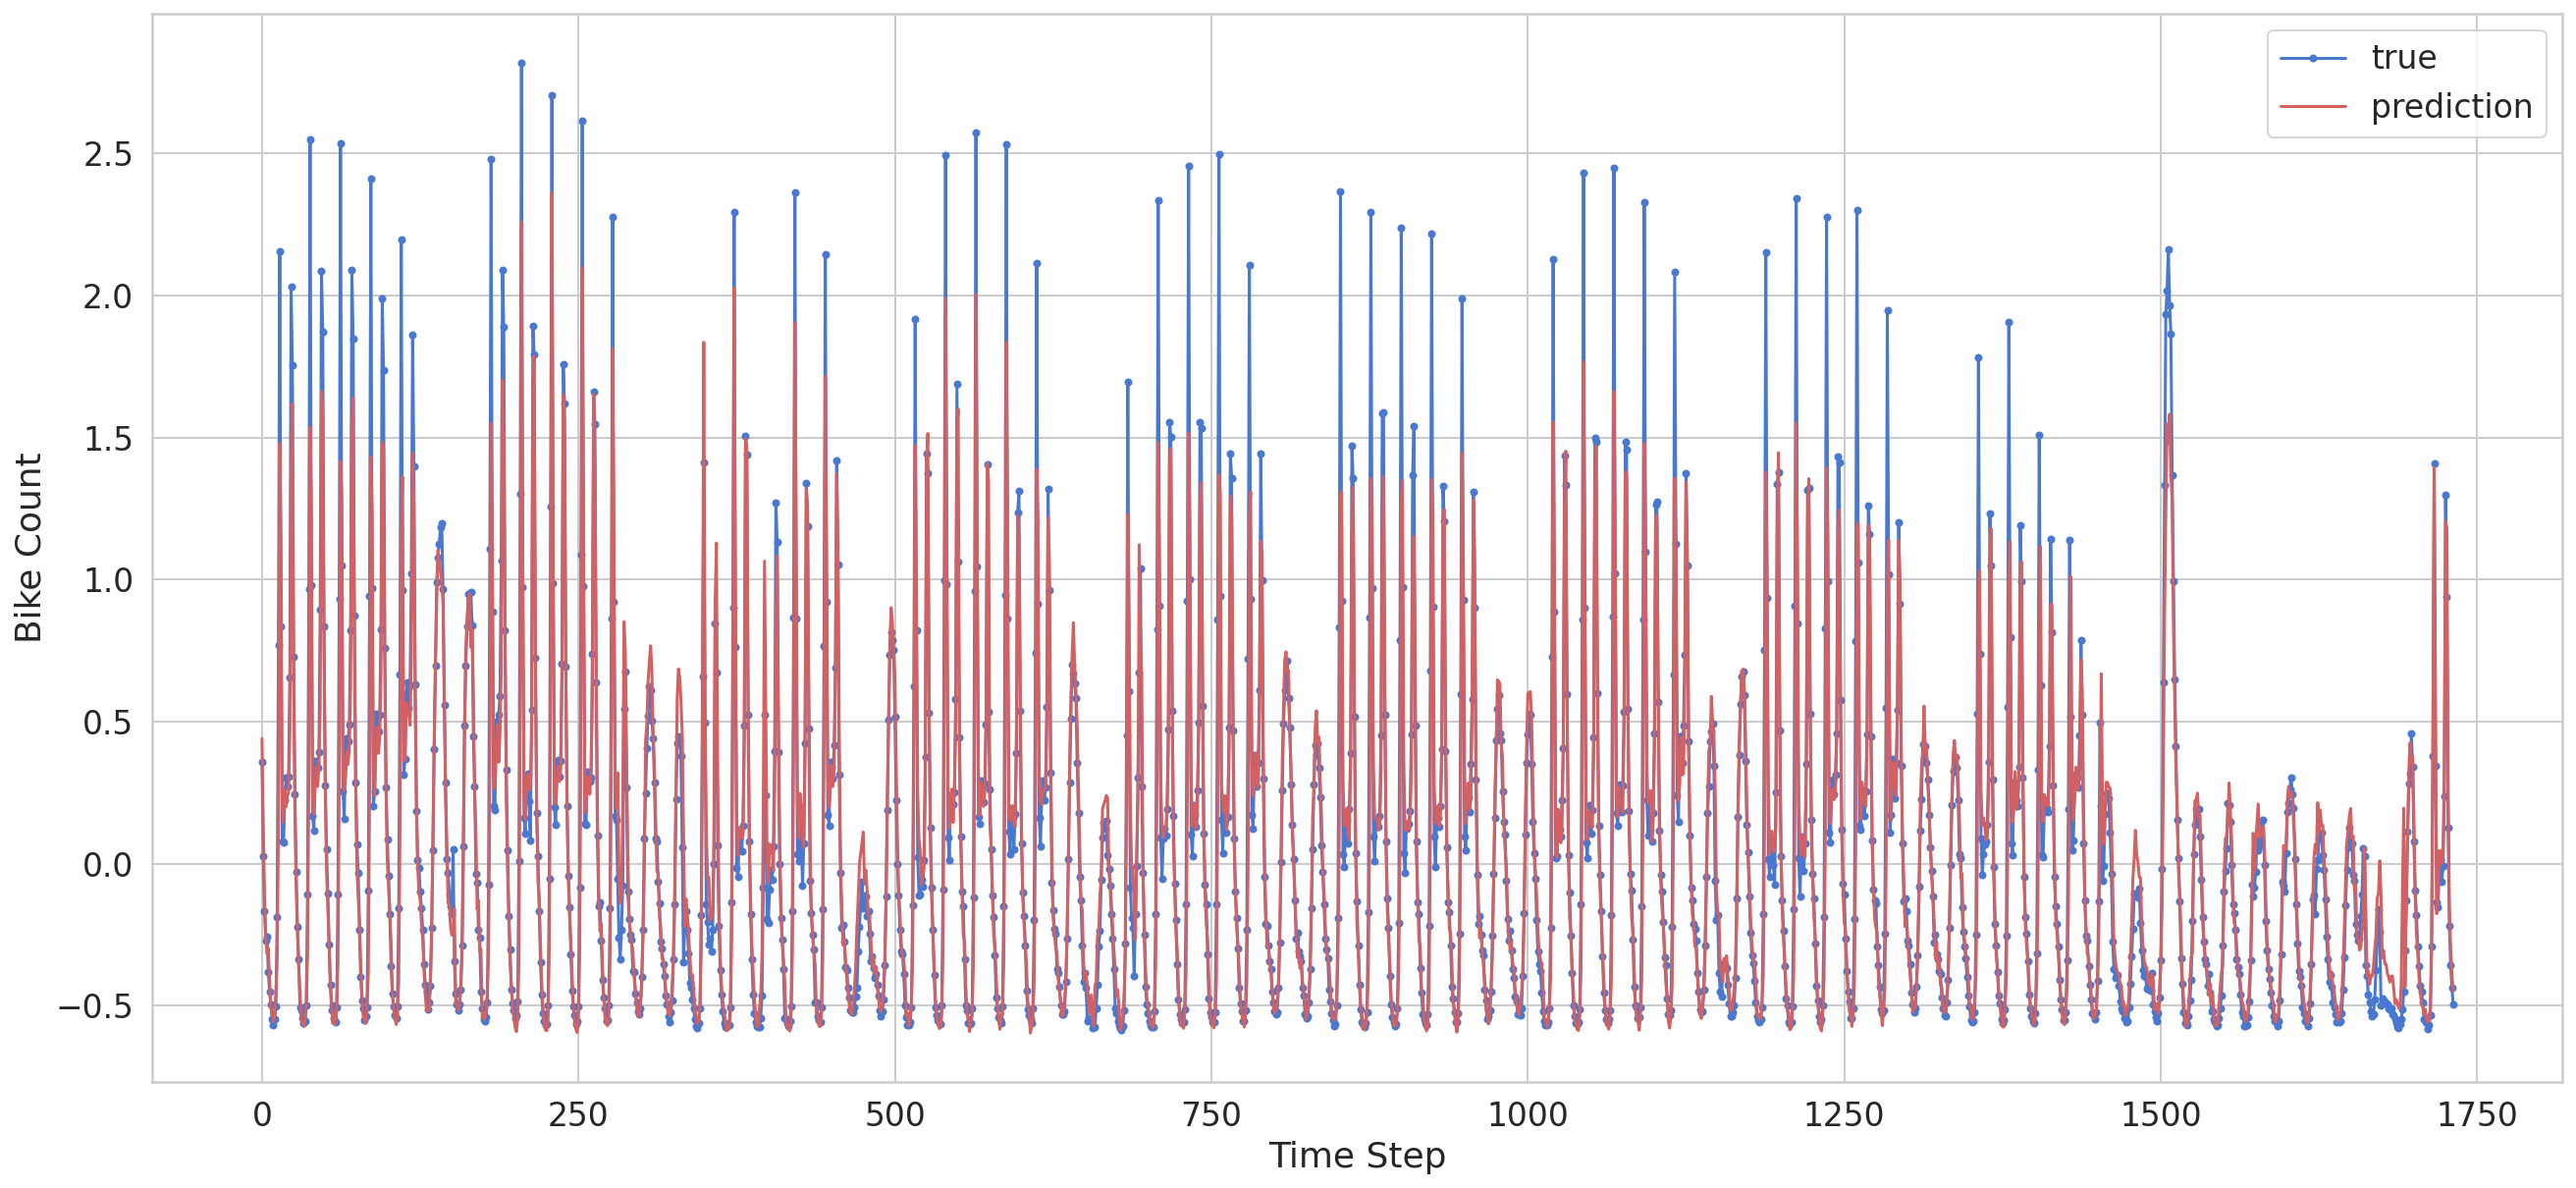

In [27]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();